# Overcoming a Theoretical Limitation of Self-Attention 

Replication of experiments on FIRST language learning from [Overcoming a Theoretical Limitation of Self-Attention  (Chiang and Cholak, 2022)](https://arxiv.org/pdf/2202.12172.pdf).

In [1]:
from src.transformer import FirstTransformer, FirstExactTransformer
import torch
import pandas as pd

Set the following to true to use the FirstExactTransformer, and to false to use FirstTransformer

In [2]:
EXACT = True

## Learning FIRST

Define training parameters as in the original paper. Citing from (David Chiang and Peter Cholak, 2020):
> We used `d_model` = 16 for word encodings, self-attention, and FFNN outputs, and `d_FFNN` = 64 for FFNN hidden layers. We used layer normalization (ε = 10^−5) after residual connections. We used PyTorch’s default initialization and trained using Adam (Kingma and Ba, 2015) with learning rate 3 × 10^−4 (Karpathy, 2016). We did not use dropout, as it did not seem to help.

In [3]:
log_sigmoid = torch.nn.LogSigmoid()
alphabet = ["0", "1", "$"]

epochs = 10
layers = 2
heads = 1 
if EXACT:
    d_model = 6 # do not change this!
else:
    d_model = 16
d_ffnn = 64  
eps = 1e-5 # value added to denominator in layer normalization

### Generalization experiment

Load training data and convert them to Tensor.

In [4]:
train10 = pd.read_csv("data/first/train_n100_l10.csv")
train30 = pd.read_csv("data/first/train_n100_l30.csv")
train100 = pd.read_csv("data/first/train_n100_l100.csv")
train300 = pd.read_csv("data/first/train_n100_l300.csv")
test = pd.read_csv("data/first/test_n100_l1000.csv")

In [5]:
X_train10, y_train10 = train10['sequence'].values, train10['label'].values
X_train30, y_train30 = train30['sequence'].values, train30['label'].values
X_train100, y_train100 = train100['sequence'].values, train100['label'].values
X_train300, y_train300 = train300['sequence'].values, train300['label'].values
X_test, y_test = test['sequence'].values, test['label'].values

In [6]:
alphabet_index = {a:i for i,a in enumerate(alphabet)}

def _encode(s: str) -> torch.Tensor:
    t = torch.tensor([alphabet_index[c] for c in s])
    return t

X_train10 = [_encode(s) for s in X_train10]
X_train30 = [_encode(s) for s in X_train30]
X_train100 = [_encode(s) for s in X_train100]
X_train300 = [_encode(s) for s in X_train300]
X_test = [_encode(s) for s in X_test]

Initialize the Transformer to learn FIRST.

In [7]:
transformer = \
    FirstExactTransformer(len(alphabet), d_model) if EXACT \
    else FirstTransformer(len(alphabet), layers, heads, d_model, d_ffnn, scaled, eps)
optim = torch.optim.Adam(transformer.parameters(), lr=0.0003)

Training cycle.

In [8]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
plot = [(ax1, ax3, ax5), (ax2, ax4, ax6)]

for scaled in [False, True]:

    for X_train, y_train, label in [(X_train10, y_train10, "n=10"), (X_train30, y_train30, "n=30"), (X_train100, y_train100, "n=100"), (X_train300, y_train300,"n=300")]:
        
        # plots
        acc_plot, entropy_plot, att_plot = plot[scaled]

        transformer = FirstTransformer(len(alphabet), layers, heads, d_model, d_ffnn, scaled, eps)
        optim = torch.optim.Adam(transformer.parameters(), lr=0.0003)
        
        train_l = []
        val_l = []
        train_acc = []
        val_acc = []

        for epoch in range(epochs):

            train_loss = train_correct = 0    
            
            # train step
            for x, y in zip(X_train, y_train):

                output = transformer(x)

                if not y: output = -output

                if output > 0: train_correct += 1

                loss = -log_sigmoid(output)
                train_loss += loss.item()
                optim.zero_grad()
                loss.backward()
                optim.step()

            # save statistic about training step
            train_l.append(train_loss) # loss
            train_acc.append(train_correct/len(X_train)) # accuracy
                
            # validation step
            with torch.no_grad():

                test_loss = test_correct = 0

                for x, y in zip(X_test, y_test):

                    output = transformer(x)

    # print step info
    print(f"[Epoch {epoch+1}] --> Train acc: {train_correct/len(X_train)} Train loss: {train_loss}, Test acc: {test_correct/len(X_test)} Test loss: {test_loss}", flush=True)

[Epoch 1] --> Train acc: 0.538 Train loss: 687.7717269062996, Test acc: 0.538 Test loss: 684.6010890007019
[Epoch 2] --> Train acc: 0.538 Train loss: 680.4441966414452, Test acc: 0.538 Test loss: 663.8430480957031
[Epoch 3] --> Train acc: 0.957 Train loss: 180.063490527682, Test acc: 1.0 Test loss: 15.207884524948895
[Epoch 4] --> Train acc: 1.0 Train loss: 6.782103429548442, Test acc: 1.0 Test loss: 2.8516633837716654
[Epoch 5] --> Train acc: 1.0 Train loss: 1.6975164163741283, Test acc: 1.0 Test loss: 0.9675771602778696
[Epoch 6] --> Train acc: 1.0 Train loss: 0.6396705122460844, Test acc: 1.0 Test loss: 0.40732408277108334
[Epoch 7] --> Train acc: 1.0 Train loss: 0.28342520295700524, Test acc: 1.0 Test loss: 0.19059356731304433
[Epoch 8] --> Train acc: 1.0 Train loss: 0.13651136794214835, Test acc: 1.0 Test loss: 0.09469729633929092
[Epoch 9] --> Train acc: 1.0 Train loss: 0.06905390826250368, Test acc: 1.0 Test loss: 0.04882823375737644
[Epoch 10] --> Train acc: 1.0 Train loss: 0.0

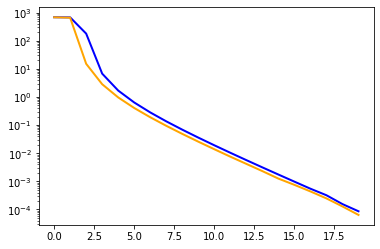

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(epoch+1), train_l, color='blue', lw=2)
plt.plot(range(epoch+1), val_l, color='orange', lw=2)
plt.yscale('log')
plt.show()

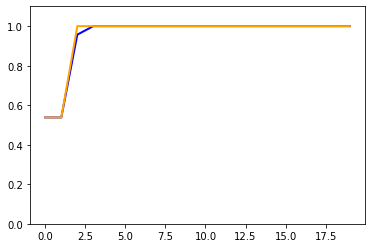

In [10]:
fig = plt.figure()
plt.plot(range(epoch+1), train_acc, color='blue', lw=2)
plt.plot(range(epoch+1), val_acc, color='orange', lw=2)
plt.ylim([0, 1.1])

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='lower center',  ncol=4)